### This Notebook contains the code to Forecast the weekly sales at a Store Level for all 45 stores, by training Feed Forward Neural Networks (FFNN) using Backpropagation. 
#### The approaches used & experiments carried out (Moving Window & single model) have been discussed below

In [1]:
from __future__ import print_function
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import math
import numpy as np

#### Reading Store level data

In [2]:
store_lvl_df = pd.read_csv('data/sales_forecasting_store_level.csv')

#### Here, Weekly_sales_sum is the target variable that captures the weekly sales of every store. 

In [3]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0


#### Creating a periodic week_nbr column to capture week of the year value between 1 & 52. This column can capture the seasonality by holding the week of the year value

In [4]:
a = []
for el in store_lvl_df.week_nbr:
    if el>52 and el<=104:
        a.append(el-52)
    elif el>104:
        a.append(el-104)
    else:
        a.append(el)
week_nbr_periodic = pd.Series(a)
cols = list(store_lvl_df.columns)
cols.append('week_nbr_periodic')
store_lvl_df = pd.concat([store_lvl_df, week_nbr_periodic], axis = 1)
store_lvl_df.columns = cols

In [5]:
### Vary from Weeks 1 to 52 & repeat
print(store_lvl_df.columns)
print(store_lvl_df.week_nbr_periodic.unique())

Index(['Weekly_Sales_sum', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'week_nbr', 'Size', 'Type_A', 'Type_B',
       'Type_C', 'week_nbr_periodic'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]


In [6]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


## APPROACH EXPERIMENT 1: Train 45 FFNN Models for each of the 45 stores using 5 lagged Moving Window
##### (Treating as Time Series data by using the previous 5 week sales as inputs)

We are going to train a seperate FFNN model for every store by using 5 previous week sales values as input along with other existing input attributes such as Temperature, Fuel_Price, CPI, Unemployment & IsHoliday.
We are training a seperate model for each store because the time series sales trend varies from store to store and hence, in order to make accurate forecasts by capturing the unique trend for each store, we are experimenting with this approach.
Also, since we are using moving window with lag of 5, where 5 previous output values are provided as input, we will have to train a seperate FFNN model for each store.

### 1. A. Training FFNN Model for each store on Train Data using all the input attributes
##### Creating a dictionary of 90 tensor objects (Train & Test objects) for the 45 stores & Dictionary of Dataframes from Visualization purposes
Creating a Tensor Object using the DataLoader function and specifying the batch size to perform mini-batch gradient descent.
The algorithm will update weights after each batch. Here the train_loader dataset has the predictor variables and the target variable in it

In [7]:
%%capture
stores_dict_df = {}
stores_dict = {}   ### Creating a dictionary containing the 45 stores
no_lags = 5  ### Moving Window approach - number of lagged previous sales values

for i in range(1,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
    
    Sales_lag1=store.Weekly_Sales_sum.shift(1)    ### Creating 5 series with lagged values of sales
    Sales_lag2=store.Weekly_Sales_sum.shift(2)
    Sales_lag3=store.Weekly_Sales_sum.shift(3)
    Sales_lag4=store.Weekly_Sales_sum.shift(4)
    Sales_lag5=store.Weekly_Sales_sum.shift(5)
        
    store_cols = list(store.columns)
    for el in ['Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']:
        store_cols.append(el)
        
    ### CONCATENATING Store DF with Lagged value Series columns to create the additional columns
    store = pd.concat([store, Sales_lag1, Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5], axis=1).dropna()
    store.columns = store_cols
    
    store = store.drop(columns=['Date'])
    
    ### Splitting every store data into Train & Test
    store_train = store.iloc[:100,]
    store_test = store.iloc[100:,]
    
    ### Applying MinMax Scaler to normalize the data
    ### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
    ### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
    scaler = MinMaxScaler()
    scaler = scaler.fit(store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                                    'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
    store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']] = scaler.transform(store_train[['Weekly_Sales_sum','Temperature',
                                                                                    'Fuel_Price','CPI','Unemployment','Size',
                                                                                    'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
    store_test[['Weekly_Sales_sum','Temperature',
                'Fuel_Price','CPI','Unemployment','Size',
               'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']] = scaler.transform(store_test[[
                'Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
    
    
    stores_dict_df["store_{}_train".format(i)] = store_train
    stores_dict_df["store_{}_test".format(i)] = store_test
    
    
    train_target = torch.tensor(store_train['Weekly_Sales_sum'].values.astype(np.float32))
    train = torch.tensor(store_train[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']].values.astype(np.float32)) 
    train_tensor = torch.utils.data.TensorDataset(train, train_target) 
    train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = len(train), shuffle = False)

    test_target = torch.tensor(store_test['Weekly_Sales_sum'].values.astype(np.float32))
    test = torch.tensor(store_test[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']].values.astype(np.float32)) 
    test_tensor = torch.utils.data.TensorDataset(test, test_target) 
    test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(test),shuffle = False)
    
    
    ### APPENDING Store Train & Test LOADERs to dictionary
    stores_dict["store_{}_train".format(i)] = train_loader
    stores_dict["store_{}_test".format(i)] = test_loader

In [8]:
len(stores_dict)

90

In [9]:
stores_dict['store_1_test'].batch_size

38

In [10]:
stores_dict['store_2_train'].batch_size

100

We inherit from nn.Module and then use super().init() method to get a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from nn.Module.
The module automatically creates the weight and bias tensors as soon as we call the nn.Linear() function. We'll use these weights and bias in the forward method. The nn.Linear() function thus creates a linear transformation with the given number of inputs and outputs. The 1st parameter is the number of inputs to the layer (equal to number of attributes in data, for 1st hidden layer) and the 2nd parameter is the number of outputs from the layer (basically equal to the number of nodes in a given layer)
The forward method takes in the data/tensor 'x' and passes through layers created in the init method and produces the required output after applying the required activation functions.

In [11]:
class ann(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,train):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], 2*train.shape[1])  ## 1st hidden layer with 'd' inputs & '2d' outputs
        self.oput_layer = nn.Linear(2*train.shape[1],1) ## output layer with '2d' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output

In [12]:
### FUNCTION TO CALCULATE TEST MSE
def test_mse(model):
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs,targets in stores_dict['store_1_test']:
            output = model(inputs)
            loss = criterion(output, targets)
    return loss.item()

#### CALCULATING TRAIN & TEST MSE after every Weight Updation for Store 1, to identify the optimum number of Epochs for this problem

In [13]:
%%capture
model = ann(train)  ### Initiate the ANN class object named model

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 60
train_MSE_aft_weight_upd = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    for inputs,targets in stores_dict['store_1_train']:    
           # Training pass
        output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd.append(loss.item())
        test_MSE_aft_weight_upd.append(test_mse(model))

*Identified 60 epochs as the optimum number*

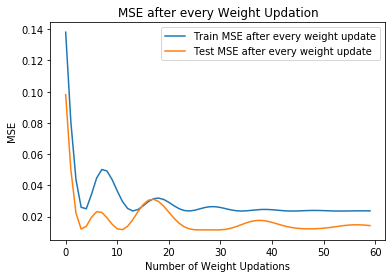

In [14]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd)
ax1.plot(weight_updates, test_MSE_aft_weight_upd)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()

In [15]:
%%capture
mse_train = []
mse_test = []
Y_pred_train_lst = []
Y_pred_test_lst = []

for i in range(1,int(len(stores_dict)/2)+1):
    train_loader = stores_dict["store_{}_train".format(i)]
    test_loader = stores_dict["store_{}_test".format(i)]
    
    model1 = ann(train)  ### Initiate the ANN class object named model, by passing the train object

    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    
    optimizer = optim.Adam(model1.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate
    
    epochs = 60
    
    ### Training the dataset.
    for e in range(epochs):
        for inputs,targets in train_loader:    
           # Training pass
            output = model1(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
    
    ### Make Predictions on Train & Test data & calculating their respective MSEs
    with torch.no_grad():
        for inputs_train,targets_train in train_loader:
            Y_pred_train = model1(inputs_train)  ### Week level Predicted Sales for each store's train data
            mse_train.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
            
    with torch.no_grad():    
        for inputs_test,targets_test in test_loader:
            Y_pred_test = model1(inputs_test)  ### Weekly Predicted Sales for each store's test data
            mse_test.append(criterion(Y_pred_test, targets_test))  ## MSE for a store's test data
    
    ### Append Weekly Predictions of each store into a list
    Y_pred_train_lst.append([el[0] for el in Y_pred_train.tolist()])
    Y_pred_test_lst.append([el[0] for el in Y_pred_test.tolist()])

#### Average Test MSE across all 45 stores

In [16]:
sum(mse_test)/len(mse_test)

tensor(0.0185)

#### Average Train MSE across all 45 stores
The Train & Test MSE are in line and the overall MSE using the FFNN approach is obtained by calculating the average of MSEs obtained on the predictions made for each store.

In [17]:
sum(mse_train)/len(mse_train)

tensor(0.0275)

##### The stores 20 & 4 are the top 2 stores, with highest sales

In [18]:
store_agg_df = store_lvl_df.groupby(['Store'],as_index=False).agg({'Weekly_Sales_sum': ['sum']})
store_agg_df.columns = ["_".join(x) for x in store_agg_df.columns.ravel()]
store_agg_df = store_agg_df.sort_values(['Weekly_Sales_sum_sum'], ascending=[False])
store_agg_df.head(4)

,Store_,Weekly_Sales_sum_sum
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08


#### Plotting Actual Vs Predicted Sales using APPROACH 1A, for Train & Test Data of Stores 20 & 4 (Top store 1)

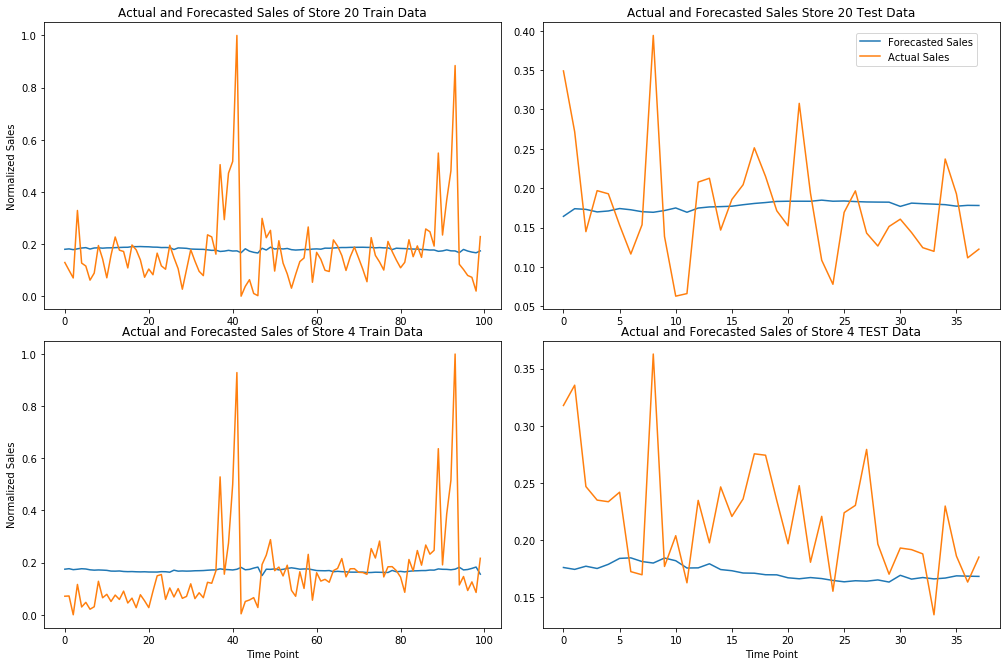

In [19]:
time_point_train = [el for el in range(0,100)]
time_point_test = [el for el in range(0,38)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 TRAIN
axs[0, 0].plot(time_point_train, Y_pred_train_lst[19])
axs[0, 0].plot(time_point_train, list(stores_dict_df["store_20_train"]["Weekly_Sales_sum"]))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20 Train Data')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 20 TEST
axs[0, 1].plot(time_point_test, Y_pred_test_lst[19])  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_test, list(stores_dict_df["store_20_test"]["Weekly_Sales_sum"]))
axs[0, 1].set_title('Actual and Forecasted Sales Store 20 Test Data')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, Y_pred_train_lst[3])
axs[1, 0].plot(time_point_train, list(stores_dict_df["store_4_train"]["Weekly_Sales_sum"]))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 4 Train Data')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_test, Y_pred_test_lst[3])
axs[1, 1].plot(time_point_test, list(stores_dict_df["store_4_test"]["Weekly_Sales_sum"]))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 4 TEST Data')
axs[1, 1].set_xlabel('Time Point')

plt.show()

### 1. B. Fitting FFNN Model for each store on Train Data using only 'week_nbr_periodic', 'IsHoliday' attributes and a higher number of lag attributes
Creating a dictionary of 90 tensor objects (Train & Test objects) for the 45 stores
Creating a Tensor Object using the DataLoader function and specifying the batch size. The algorithm will update weights after each batch. Here the train_loader dataset has the predictor variables and the target variable in it

In [20]:
%%capture
stores_dict2 = {}   ### Creating a dictionary containing the 45 stores
stores_dict_df2 = {}
no_lags = 10  ### Moving Window approach - number of lagged previous sales values

for i in range(1,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
    
    Sales_lag1=store.Weekly_Sales_sum.shift(1)    ### Creating 10 series with lagged values of sales
    Sales_lag2=store.Weekly_Sales_sum.shift(2)
    Sales_lag3=store.Weekly_Sales_sum.shift(3)
    Sales_lag4=store.Weekly_Sales_sum.shift(4)
    Sales_lag5=store.Weekly_Sales_sum.shift(5)
    Sales_lag6=store.Weekly_Sales_sum.shift(6)
    Sales_lag7=store.Weekly_Sales_sum.shift(7)
    Sales_lag8=store.Weekly_Sales_sum.shift(8)
    Sales_lag9=store.Weekly_Sales_sum.shift(9)
    Sales_lag10=store.Weekly_Sales_sum.shift(10)
        
    store_cols = list(store.columns)
    for el in ['Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5','Sales_lag6','Sales_lag7','Sales_lag8'
              ,'Sales_lag9','Sales_lag10']:
        store_cols.append(el)
        
    ### CONCATENATING Store DF with Lagged value Series columns to create the additional columns
    store = pd.concat([store, Sales_lag1, Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5,Sales_lag6,Sales_lag7,
                      Sales_lag8,Sales_lag9,Sales_lag10], axis=1).dropna()
    store.columns = store_cols
    
    store = store.drop(columns=['Date'])
    
    ### Splitting every store data into Train & Test
    store_train = store.iloc[:100,]
    store_test = store.iloc[100:,]
    
    ### Applying MinMax Scaler to normalize the data
    ### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
    ### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
    scaler = MinMaxScaler()
    scaler = scaler.fit(store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                                    'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5',
                                    'Sales_lag6','Sales_lag7','Sales_lag8','Sales_lag9','Sales_lag10']])
    store_train[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5','Sales_lag6','Sales_lag7','Sales_lag8',
               'Sales_lag9','Sales_lag10']] = scaler.transform(store_train[['Weekly_Sales_sum','Temperature',
                                                                                    'Fuel_Price','CPI','Unemployment','Size',
                                                                                    'Sales_lag1','Sales_lag2','Sales_lag3',
                                                                                    'Sales_lag4','Sales_lag5','Sales_lag6',
                                                                        'Sales_lag7','Sales_lag8','Sales_lag9','Sales_lag10']])
    store_test[['Weekly_Sales_sum','Temperature',
                'Fuel_Price','CPI','Unemployment','Size',
               'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5',
               'Sales_lag6','Sales_lag7','Sales_lag8',
                'Sales_lag9','Sales_lag10']] = scaler.transform(store_test[[
                'Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5','Sales_lag6','Sales_lag7','Sales_lag8',
              'Sales_lag9','Sales_lag10']])
    
    ### APPENDING Store Train & Test DFs to dictionary
    stores_dict_df2["store_{}_train".format(i)] = store_train
    stores_dict_df2["store_{}_test".format(i)] = store_test
    
    
    train_target2 = torch.tensor(store_train['Weekly_Sales_sum'].values.astype(np.float32))
    train2 = torch.tensor(store_train[['IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5',
                        'Sales_lag6','Sales_lag7','Sales_lag8','Sales_lag9','Sales_lag10']].values.astype(np.float32)) 
    train_tensor2 = torch.utils.data.TensorDataset(train2, train_target2) 
    train_loader2 = torch.utils.data.DataLoader(dataset = train_tensor2, batch_size = len(train2), shuffle = False)

    test_target2 = torch.tensor(store_test['Weekly_Sales_sum'].values.astype(np.float32))
    test2 = torch.tensor(store_test[['IsHoliday','week_nbr_periodic',
                         'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5',
                        'Sales_lag6','Sales_lag7','Sales_lag8','Sales_lag9','Sales_lag10']].values.astype(np.float32)) 
    test_tensor2 = torch.utils.data.TensorDataset(test2, test_target2) 
    test_loader2 = torch.utils.data.DataLoader(dataset = test_tensor2, batch_size = len(test2),shuffle = False)
    
    
    ### APPENDING Store Train & Test LOADERs to dictionary
    stores_dict2["store_{}_train".format(i)] = train_loader2
    stores_dict2["store_{}_test".format(i)] = test_loader2

In [21]:
print(len(stores_dict2))
print(stores_dict2['store_1_test'].batch_size)
print(stores_dict2['store_2_train'].batch_size)

90
33
100


In [22]:
%%capture
mse_train2 = []
mse_test2 = []
Y_pred_train_lst2 = []
Y_pred_test_lst2 = []

for i in range(1,int(len(stores_dict2)/2)+1):
    train_loader2 = stores_dict2["store_{}_train".format(i)]
    test_loader2 = stores_dict2["store_{}_test".format(i)]
    
    model1 = ann(train2)  ### Initiate the ANN class object named model, by passing the train object

    criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error
    
    optimizer = optim.Adam(model1.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate
    
    epochs = 60
    
    ### Training the dataset.
    for e in range(epochs):
        for inputs,targets in train_loader2:    
           # Training pass
            output = model1(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
            loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
            loss.backward()   ### Backpropogating based on the loss 
            optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
            optimizer.zero_grad() ### Erasing the gradient values after every weight update
    
    ### Make Predictions on Train & Test data & calculating their respective MSEs
    with torch.no_grad():
        for inputs_train,targets_train in train_loader2:
            Y_pred_train2 = model1(inputs_train)  ### Week level Predicted Sales for each store's train data
            mse_train2.append(criterion(Y_pred_train, targets_train))  ## MSE for a store's train data
            
    with torch.no_grad():    
        for inputs_test,targets_test in test_loader2:
            Y_pred_test2 = model1(inputs_test)  ### Weekly Predicted Sales for each store's test data
            mse_test2.append(criterion(Y_pred_test2, targets_test))  ## MSE for a store's test data
    
    ### Append Weekly Predictions of each store into a list
    Y_pred_train_lst2.append([el[0] for el in Y_pred_train2.tolist()])
    Y_pred_test_lst2.append([el[0] for el in Y_pred_test2.tolist()])

#### Average Test MSE across all 45 stores

In [23]:
sum(mse_test2)/len(mse_test2)

tensor(0.0165)

#### Average Train MSE across all 45 stores
The Train & Test MSE are in line and the overall MSE using the FFNN approach is obtained by calculating the average of MSEs obtained on the predictions made for each store.

In [24]:
sum(mse_train2)/len(mse_train2)

tensor(0.0455)

#### Plotting Actual Vs Predicted Sales using Approach 1B, on Train & Test Data of Stores 20 & 4

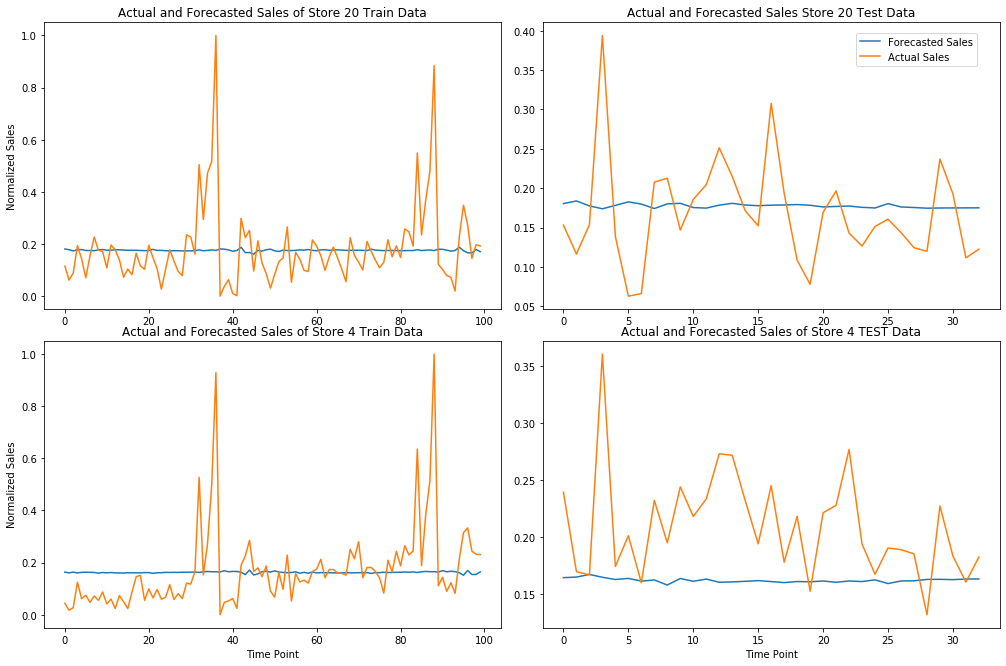

In [25]:
time_point_train = [el for el in range(0,100)]
time_point_test = [el for el in range(0,33)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 TRAIN
axs[0, 0].plot(time_point_train, Y_pred_train_lst2[19])
axs[0, 0].plot(time_point_train, list(stores_dict_df2["store_20_train"]["Weekly_Sales_sum"]))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20 Train Data')
axs[0, 0].set_ylabel('Normalized Sales')

### STORE 20 TEST
axs[0, 1].plot(time_point_test, Y_pred_test_lst2[19])  ### 19th index in a list indexed from 0 to 44
axs[0, 1].plot(time_point_test, list(stores_dict_df2["store_20_test"]["Weekly_Sales_sum"]))
axs[0, 1].set_title('Actual and Forecasted Sales Store 20 Test Data')


### STORE 4 TRAIN
axs[1, 0].plot(time_point_train, Y_pred_train_lst2[3])
axs[1, 0].plot(time_point_train, list(stores_dict_df2["store_4_train"]["Weekly_Sales_sum"]))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 4 Train Data')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Normalized Sales')

### STORE 4 TEST
axs[1, 1].plot(time_point_test, Y_pred_test_lst2[3])
axs[1, 1].plot(time_point_test, list(stores_dict_df2["store_4_test"]["Weekly_Sales_sum"]))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 4 TEST Data')
axs[1, 1].set_xlabel('Time Point')

plt.show()

#### Conclusion: We can observe that both the FFNN models built using approach 1A & 1B are not able to accurately forecast the sales. For example the actual sales value for both store 20 & store 4 are peaking to a very high value around the holiday weeks of 40, while the model is not able to forecast any of the peaks & dips. 

## APPROACH EXPERIMENT 2: Train One single FFNN Model

In the approach, the time series aspect (moving window technique) along with the characteristics of a store ('store type', 'store size'), other external characteristics ('Temperature','Fuel_Price','CPI','Unemployment','IsHoliday') along with week of the year ('week_nbr_periodic') columns are used as input attributes to make the predictions. This is implemented by training a single FFNN model on the entire store level aggregated dataset which is common for all the stores.

In [26]:
store_lvl_df.head()

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic
0,1650399.00,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,151315,1,0,0,1
1,1675305.37,1,2010-02-12,38.51,2.548,211.242170,8.106,True,2,151315,1,0,0,2
2,1644421.11,1,2010-02-19,39.93,2.514,211.289143,8.106,False,3,151315,1,0,0,3
3,1442911.49,1,2010-02-26,46.63,2.561,211.319643,8.106,False,4,151315,1,0,0,4
4,1586448.75,1,2010-03-05,46.50,2.625,211.350143,8.106,False,5,151315,1,0,0,5


#### Creating a single unified Store Level weekly sales dataframe with 5 lagged moving window for every store

In [27]:
store_union_df = store_lvl_df[store_lvl_df['Store']==1]  ### Subsetting DF based on Store number
    
Sales_lag1=store_union_df.Weekly_Sales_sum.shift(1)    ### Creating 5 series with lagged values of sales
Sales_lag2=store_union_df.Weekly_Sales_sum.shift(2)
Sales_lag3=store_union_df.Weekly_Sales_sum.shift(3)
Sales_lag4=store_union_df.Weekly_Sales_sum.shift(4)
Sales_lag5=store_union_df.Weekly_Sales_sum.shift(5)
    
store_cols = list(store_union_df.columns)
for el in ['Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']:
    store_cols.append(el)
    
### CONCATENATING Store DF with Lagged value Series columns to create the additional columns
store_union_df = pd.concat([store_union_df, Sales_lag1, Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5], axis=1).dropna()
store_union_df.columns = store_cols

In [28]:
%%capture
no_lags = 5  ### Moving Window approach - number of lagged previous sales values

for i in range(2,len(store_lvl_df.Store.unique())+1):
    store = store_lvl_df[store_lvl_df['Store']==i]  ### Subsetting DF based on Store number
    
    Sales_lag1=store.Weekly_Sales_sum.shift(1)    ### Creating 5 series with lagged values of sales
    Sales_lag2=store.Weekly_Sales_sum.shift(2)
    Sales_lag3=store.Weekly_Sales_sum.shift(3)
    Sales_lag4=store.Weekly_Sales_sum.shift(4)
    Sales_lag5=store.Weekly_Sales_sum.shift(5)
        
    store_cols = list(store.columns)
    for el in ['Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']:
        store_cols.append(el)
        
    ### CONCATENATING Store DF with Lagged value Series columns to create the additional columns
    store = pd.concat([store, Sales_lag1, Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5], axis=1).dropna()
    store.columns = store_cols
    
    store_union_df = pd.concat([store_union_df,store])

In [29]:
store_union_df.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], dtype=int64)

#### Creating Min-Max scaled, Train and Test Loader objects for FFNN

In [30]:
%%capture
### Splitting every store data into Train & Test
store_union_train_df = store_union_df.iloc[:4350,]
store_union_test_df = store_union_df.iloc[4350:,]

### Applying MinMax Scaler to normalize the data
### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process
### Fitting the scaler on train data, i.e. taking the min & max values from train data and transforming on to test data
scaler = MinMaxScaler()
scaler = scaler.fit(store_union_train_df[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
                                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
store_union_train_df[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
            'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']] = scaler.transform(store_union_train_df[['Weekly_Sales_sum','Temperature',
                                                                                'Fuel_Price','CPI','Unemployment','Size',
                                                                                'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])
store_union_test_df[['Weekly_Sales_sum','Temperature',
            'Fuel_Price','CPI','Unemployment','Size',
           'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']] = scaler.transform(store_union_test_df[[
            'Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment','Size',
            'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']])

### Creating Train & Test Loaders
train_target3 = torch.tensor(store_union_train_df['Weekly_Sales_sum'].values.astype(np.float32))
train3 = torch.tensor(store_union_train_df[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                     'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']].values.astype(np.float32)) 
train_tensor3 = torch.utils.data.TensorDataset(train3, train_target3) 
train_loader3 = torch.utils.data.DataLoader(dataset = train_tensor3, batch_size = len(train3), shuffle = False)


test_target3 = torch.tensor(store_union_test_df['Weekly_Sales_sum'].values.astype(np.float32))                                           
test3 = torch.tensor(store_union_test_df[['Temperature','Fuel_Price','CPI','Unemployment','IsHoliday','week_nbr_periodic',
                     'Sales_lag1','Sales_lag2','Sales_lag3','Sales_lag4','Sales_lag5']].values.astype(np.float32)) 
test_tensor3 = torch.utils.data.TensorDataset(test3, test_target3) 
test_loader3 = torch.utils.data.DataLoader(dataset = test_tensor3, batch_size = len(test3),shuffle = False)


### A. TRAIN 1 single shallow FFNN model

In [31]:
%%capture
mse_train3 = []
mse_test3 = []
Y_pred_train_lst3 = []
Y_pred_test_lst3 = []

model3 = ann(train3)  ### Initiate the ANN class object named model, by passing the train obj
criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model3.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 60
    
    ### Training the dataset.
for e in range(epochs):
    for inputs,targets in train_loader3:    
       # Training pass
        output = model3(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update

### Make Predictions on Train & Test data & calculating their respective MSEs
with torch.no_grad():
    for inputs_train,targets_train in train_loader3:
        Y_pred_train3 = model3(inputs_train)  ### Week-store level Predicted Sales entire train data
        mse_train3.append(criterion(Y_pred_train3, targets_train))  ## MSE for train data
        
with torch.no_grad():    
    for inputs_test,targets_test in test_loader3:
        Y_pred_test3 = model3(inputs_test)  ### Weekly store level Predicted Sales for entire test data
        mse_test3.append(criterion(Y_pred_test3, targets_test))  ## MSE for a store's test data

    ### Append Weekly Predictions of Train & Test data into a list
Y_pred_train_lst3.append([el[0] for el in Y_pred_train3.tolist()])
Y_pred_test_lst3.append([el[0] for el in Y_pred_test3.tolist()])

#### Training MSE

In [32]:
float(mse_train3[0])

0.02687959372997284

#### Testing MSE

In [33]:
float(mse_test3[0])

0.027308477088809013

*Appending Predicted Sales column to train & test DF*

In [34]:
cols = list(store_union_train_df.columns)
cols.append('Predicted_Sales')
### Appending predicted sales column to Train DF
store_union_train_df1 = pd.concat([store_union_train_df.reset_index(), pd.Series(Y_pred_train_lst3[0])], axis = 1,ignore_index=True)
store_union_train_df1 = store_union_train_df1.drop(columns=[0])
store_union_train_df1.columns = cols

### Appending predicted sales column to Test DF
store_union_test_df1 = pd.concat([store_union_test_df.reset_index(), pd.Series(Y_pred_test_lst3[0])], axis = 1,ignore_index=True)
store_union_test_df1 = store_union_test_df1.drop(columns=[0])
store_union_test_df1.columns = cols

In [35]:
store_union_train_df1

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5,Predicted_Sales
0,0.345293,1,2010-03-12,0.565193,0.053600,0.843310,0.563760,False,6,0.630267,1,0,0,6,0.378031,0.337121,0.394554,0.403357,0.396258,0.257392
1,0.354063,1,2010-03-19,0.531505,0.081450,0.841679,0.563760,False,7,0.630267,1,0,0,7,0.345293,0.378031,0.337121,0.394554,0.403357,0.256141
2,0.334341,1,2010-03-26,0.498655,0.087756,0.839726,0.563760,False,8,0.630267,1,0,0,8,0.354063,0.345293,0.378031,0.337121,0.394554,0.256505
3,0.388024,1,2010-04-02,0.612211,0.080925,0.837773,0.519573,False,9,0.630267,1,0,0,9,0.334341,0.354063,0.345293,0.378031,0.337121,0.257247
4,0.374360,1,2010-04-09,0.649888,0.107725,0.835819,0.519573,False,10,0.630267,1,0,0,10,0.388024,0.334341,0.354063,0.345293,0.378031,0.257399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,0.260088,32,2011-06-24,0.641492,0.575933,0.661610,0.636269,False,73,0.910066,1,0,0,21,0.266922,0.280311,0.259058,0.260906,0.252230,0.259546
4346,0.271031,32,2011-07-01,0.723353,0.542302,0.662547,0.640273,False,74,0.910066,1,0,0,22,0.260088,0.266922,0.280311,0.259058,0.260906,0.259751
4347,0.245688,32,2011-07-08,0.720204,0.512349,0.663484,0.640273,False,75,0.910066,1,0,0,23,0.271031,0.260088,0.266922,0.280311,0.259058,0.260241
4348,0.257193,32,2011-07-15,0.699109,0.508145,0.664716,0.640273,False,76,0.910066,1,0,0,24,0.245688,0.271031,0.260088,0.266922,0.280311,0.259671


#### Plotting Actual Vs Predicted Sales using Approach 2, on Stores 20 & 4

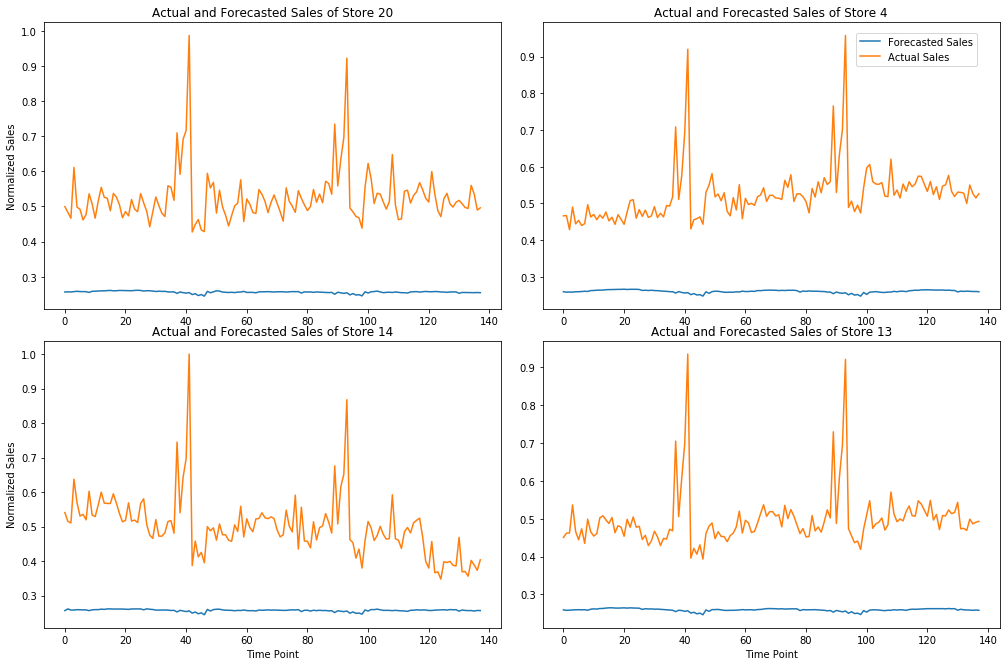

In [36]:
time_point_train = [el for el in range(0,138)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 
axs[0, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==20].Predicted_Sales))
axs[0, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==20].Weekly_Sales_sum))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20')
axs[0, 0].set_ylabel('Normalized Sales')


### STORE 4 
axs[0, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==4].Predicted_Sales))
axs[0, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==4].Weekly_Sales_sum))
axs[0, 1].set_title('Actual and Forecasted Sales of Store 4')


### STORE 14
axs[1, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==14].Predicted_Sales))
axs[1, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==14].Weekly_Sales_sum))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 14')
axs[1, 0].set_ylabel('Normalized Sales')
axs[1, 0].set_xlabel('Time Point')

### STORE 13
axs[1, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==13].Predicted_Sales))
axs[1, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==13].Weekly_Sales_sum))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 13')
axs[1, 1].set_xlabel('Time Point')

plt.show()

#### COMPARISON

In [39]:
Comparison_dict = {}
Comparison_dict['FFNN Methods'] = ['45 models:Moving Window-all inputs','45 models:Moving Window-select inputs','1 model']
Comparison_dict['Train_MSE'] = [float(sum(mse_train)/len(mse_train)),float(sum(mse_train2)/len(mse_train2)),float(mse_train3[0])]
Comparison_dict['Test_MSE'] = [float(sum(mse_test)/len(mse_test)),float(sum(mse_test2)/len(mse_test2)),float(mse_test3[0])]
pd.DataFrame.from_dict(Comparison_dict)

,FFNN Methods,Train_MSE,Test_MSE
0,45 models:Moving Window-all inputs,0.027448,0.018951
1,45 models:Moving Window-select inputs,0.051878,0.017428
2,1 model,0.026912,0.029173


### B. TRAIN 1 single deep FFNN model with 3 hidden layers

In [37]:
class ann_deep(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self,train):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], 2*train.shape[1])  ## 1st hidden layer with 'd' inputs & '2d' outputs
        self.hidden_layer2 = nn.Linear(2*train.shape[1], 2*train.shape[1])  ## 2nd hidden layer with '2d' inputs & '2d' outputs
        self.hidden_layer3 = nn.Linear(2*train.shape[1], 2*train.shape[1])  ## 3rd hidden layer with '2d' inputs & '2d' outputs
        
        self.oput_layer = nn.Linear(2*train.shape[1],1) ## output layer with '2d' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        out = F.sigmoid(self.hidden_layer2(out))  ## Compute output of 2nd hidden layer after applying the Sigmoid function
        out = F.sigmoid(self.hidden_layer3(out))  ## Compute output of 3rd hidden layer after applying the Sigmoid function
        
        output = self.oput_layer(out)   ## compute output of output layer
        return output

In [38]:
%%capture
mse_train4 = []
mse_test4 = []
Y_pred_train_lst4 = []
Y_pred_test_lst4 = []

model3 = ann_deep(train3)  ### Initiate the ANN class object named model, by passing the train obj
criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model3.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 60
    
    ### Training the dataset.
for e in range(epochs):
    for inputs,targets in train_loader3:    
       # Training pass
        output = model3(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update

### Make Predictions on Train & Test data & calculating their respective MSEs
with torch.no_grad():
    for inputs_train,targets_train in train_loader3:
        Y_pred_train3 = model3(inputs_train)  ### Week-store level Predicted Sales entire train data
        mse_train4.append(criterion(Y_pred_train3, targets_train))  ## MSE for train data
        
with torch.no_grad():    
    for inputs_test,targets_test in test_loader3:
        Y_pred_test3 = model3(inputs_test)  ### Weekly store level Predicted Sales for entire test data
        mse_test4.append(criterion(Y_pred_test3, targets_test))  ## MSE for a store's test data

    ### Append Weekly Predictions of Train & Test data into a list
Y_pred_train_lst4.append([el[0] for el in Y_pred_train3.tolist()])
Y_pred_test_lst4.append([el[0] for el in Y_pred_test3.tolist()])

#### Training MSE

In [39]:
float(mse_train4[0])

0.026922287419438362

#### Testing MSE

In [40]:
float(mse_test4[0])

0.0257863849401474

*Appending Predicted Sales column to train & test DF*

In [41]:
cols = list(store_union_train_df.columns)
cols.append('Predicted_Sales2')
### Appending predicted sales column to Train DF
store_union_train_df1 = pd.concat([store_union_train_df.reset_index(), pd.Series(Y_pred_train_lst4[0])], axis = 1,ignore_index=True)
store_union_train_df1 = store_union_train_df1.drop(columns=[0])
store_union_train_df1.columns = cols

### Appending predicted sales column to Test DF
store_union_test_df1 = pd.concat([store_union_test_df.reset_index(), pd.Series(Y_pred_test_lst4[0])], axis = 1,ignore_index=True)
store_union_test_df1 = store_union_test_df1.drop(columns=[0])
store_union_test_df1.columns = cols

In [42]:
store_union_train_df1

,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week_nbr,Size,Type_A,Type_B,Type_C,week_nbr_periodic,Sales_lag1,Sales_lag2,Sales_lag3,Sales_lag4,Sales_lag5,Predicted_Sales2
0,0.345293,1,2010-03-12,0.565193,0.053600,0.843310,0.563760,False,6,0.630267,1,0,0,6,0.378031,0.337121,0.394554,0.403357,0.396258,0.252896
1,0.354063,1,2010-03-19,0.531505,0.081450,0.841679,0.563760,False,7,0.630267,1,0,0,7,0.345293,0.378031,0.337121,0.394554,0.403357,0.253112
2,0.334341,1,2010-03-26,0.498655,0.087756,0.839726,0.563760,False,8,0.630267,1,0,0,8,0.354063,0.345293,0.378031,0.337121,0.394554,0.253308
3,0.388024,1,2010-04-02,0.612211,0.080925,0.837773,0.519573,False,9,0.630267,1,0,0,9,0.334341,0.354063,0.345293,0.378031,0.337121,0.253433
4,0.374360,1,2010-04-09,0.649888,0.107725,0.835819,0.519573,False,10,0.630267,1,0,0,10,0.388024,0.334341,0.354063,0.345293,0.378031,0.253555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,0.260088,32,2011-06-24,0.641492,0.575933,0.661610,0.636269,False,73,0.910066,1,0,0,21,0.266922,0.280311,0.259058,0.260906,0.252230,0.254129
4346,0.271031,32,2011-07-01,0.723353,0.542302,0.662547,0.640273,False,74,0.910066,1,0,0,22,0.260088,0.266922,0.280311,0.259058,0.260906,0.254141
4347,0.245688,32,2011-07-08,0.720204,0.512349,0.663484,0.640273,False,75,0.910066,1,0,0,23,0.271031,0.260088,0.266922,0.280311,0.259058,0.254150
4348,0.257193,32,2011-07-15,0.699109,0.508145,0.664716,0.640273,False,76,0.910066,1,0,0,24,0.245688,0.271031,0.260088,0.266922,0.280311,0.254165


#### Plotting Actual Vs Predicted Sales using Approach 2B (deep network), on Stores 20 & 4

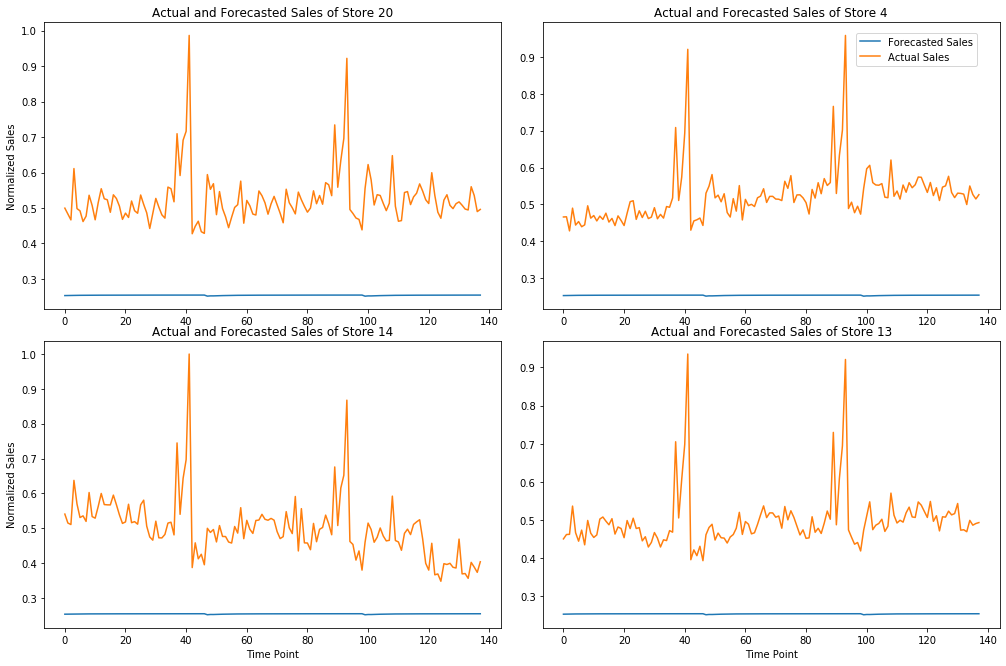

In [43]:
time_point_train = [el for el in range(0,138)]

plt.rcParams["figure.figsize"] = [14,9]
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

### STORE 20 
axs[0, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==20].Predicted_Sales2))
axs[0, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==20].Weekly_Sales_sum))
fig.legend(['Forecasted Sales', 'Actual Sales'], loc = (0.85, 0.9),ncol = 1)
axs[0, 0].set_title('Actual and Forecasted Sales of Store 20')
axs[0, 0].set_ylabel('Normalized Sales')


### STORE 4 
axs[0, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==4].Predicted_Sales2))
axs[0, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==4].Weekly_Sales_sum))
axs[0, 1].set_title('Actual and Forecasted Sales of Store 4')


### STORE 14
axs[1, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==14].Predicted_Sales2))
axs[1, 0].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==14].Weekly_Sales_sum))
axs[1, 0].set_title('Actual and Forecasted Sales of Store 14')
axs[1, 0].set_ylabel('Normalized Sales')
axs[1, 0].set_xlabel('Time Point')

### STORE 13
axs[1, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==13].Predicted_Sales2))
axs[1, 1].plot(time_point_train, list(store_union_train_df1[store_union_train_df1['Store']==13].Weekly_Sales_sum))
axs[1, 1].set_title('Actual and Forecasted Sales of Store 13')
axs[1, 1].set_xlabel('Time Point')

plt.show()

#### COMPARISON

In [44]:
Comparison_dict = {}
Comparison_dict['FFNN Methods'] = ['45 models:Moving Window-all inputs','45 models:Moving Window-select inputs','1 MODEL:shallow network','1 MODEL:deep network']
Comparison_dict['Train_MSE'] = [float(sum(mse_train)/len(mse_train)),float(sum(mse_train2)/len(mse_train2)),float(mse_train3[0]),float(mse_train4[0])]
Comparison_dict['Test_MSE'] = [float(sum(mse_test)/len(mse_test)),float(sum(mse_test2)/len(mse_test2)),float(mse_test3[0]),float(mse_test4[0])]
pd.DataFrame.from_dict(Comparison_dict)

,FFNN Methods,Train_MSE,Test_MSE
0,45 models:Moving Window-all inputs,0.027461,0.018539
1,45 models:Moving Window-select inputs,0.045481,0.016515
2,1 MODEL:shallow network,0.026880,0.027308
3,1 MODEL:deep network,0.026922,0.025786


#### CONCLUSION: We can observe that, there is no difference in performance (MSE scores ,forecast predictions) between a shallow and a deep FFNN. Hence, FFNNs are not suitable for making store level forecasts and they cannot be used for this problem.